In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import qiskit as qk
qk.IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
from system import Model,Pairing

In [3]:
def simple(Qcirc,w,ctrl,dt):
    qc = Qcirc[0]
    qb = Qcirc[1]
    cb = Qcirc[2]
    
    qc.cx(qb[w],qb[-1])
    qc.cx(qb[w],qb[-1])
    qc.crz(2*dt,qb[ctrl],qb[w+1])
    
    qc.u1(2*dt,qb[ctrl])

    return [qc,qb,cb]

In [4]:
class Heisenberg(Model):
    def __init__(self,*args):
        super().__init__(*args)
        self.h0 = self.args[0]
        self.ansatz()
    
    def __call__(self,ctrl,dt):
        qc = self.qc
        qb = self.qb
        w = self.w
        h0 = self.h0
        
        ### ONEBODY ###
        #qc.crz(h0*dt,qb[ctrl],qb[w+0])
        #qc.crz(h0*dt,qb[ctrl],qb[w+1])

        ### TWOBODY ###
        ##### X #####
        qc.cx(qb[w+1],qb[w+0])
        qc.h(qb[w+1])
        qc.crz(2*dt,qb[ctrl],qb[w+1])
        qc.h(qb[w+1])
        qc.cx(qb[w+1],qb[w+0])
        ##### Y #####
        qc.rz(np.pi/2,qb[w+0])
        qc.rz(np.pi/2,qb[w+1])
        qc.cx(qb[w+1],qb[w+0])
        qc.h(qb[w+1])
        qc.crz(2*dt,qb[ctrl],qb[w+1])
        qc.h(qb[w+1])
        qc.cx(qb[w+1],qb[w+0])
        qc.rz(-np.pi/2,qb[w+0])
        qc.rz(-np.pi/2,qb[w+1])
        ##### Z #####
        qc.cx(qb[w+1],qb[w+0])
        qc.crz(2*dt,qb[ctrl],qb[w+0])
        qc.cx(qb[w+1],qb[w+0])
        
        qc.u1(Emax*dt,qb[ctrl])

        self.qc = qc
        self.qb = qb
        
        return self
    
    def ansatz(self):
        for i in range(self.s):
            self.qc.h(self.qb[self.w+i])
        return None

In [8]:
def InvFourierTransform(model):
    qc = model.qc
    qb = model.qb
    w = model.w
    
    for i in range(int(w/2)):
        qc.swap(qb[i],qb[w-i-1])   
    for i in range(w):
        for j in range(i):
            qc.cu1(-2*np.pi/2**(i-j+1),qb[j],qb[i])
        qc.h(qb[i])

    model.qc = qc
    model.qb = qb
    return model

In [9]:
def PhaseEstimation(model,t=0.5,dt=0.005):

    s = model.s
    w = model.w
    
    # Initialize / Create superposition
    for i in range(w):
        model.qc.h(model.qb[i])
    
    # model ansatz in model.__init__
        
    # Apply controlled-U operations
    for i in range(model.w):
        for n in range(int(t/dt)):
            model = model(w-1-i,(2**i)*dt)
    
    # Inverse Quantum Fourier Transform
    model = InvFourierTransform(model)
        
    # Measurement
    model = model.measure(t)
    
    return model

In [10]:
dt = 0.005
steps = 100
t = steps*dt

h0 = 1
delta = 1
g = 1
Emax = 2
sim = 4
work = 6
ancilla = 1
#model = Pairing(work,sim,ancilla,Emax,delta,g)
model = Pairing(6,4,1,2,1,1)
#model = Heisenberg(8,2,0,4,1)

model = PhaseEstimation(model,t=t,dt=dt)

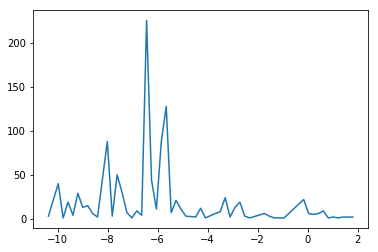

In [11]:
x = model.plotX
y = model.plotY
plt.plot(x,y)
plt.show()

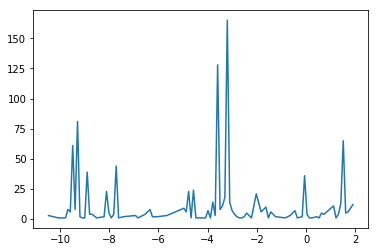

In [12]:
res = model.result
measurements = []
for key,value in res.items():
    key_ = key[sim:]
    eigenstate = key[1:(sim)]
    eigenstate = eigenstate[::-1]
    decimal = 0
    for i,bit in enumerate(key_):
        decimal += int(bit)*2**(-i-1)
    if value != 0:
        measurements.append(np.array([eigenstate, model.Emax-decimal*2*np.pi/t, value]))

measurements = np.array(measurements)
x = measurements[:,1]
y = measurements[:,2]
idx = np.argsort(x)
x = x[idx]
y = y[idx]
eigdict = {}
for xi in x:
    eigdict[xi] = 0
for xi, yi in zip(x,y):
    eigdict[xi] += int(yi)

x = np.array(list(eigdict.keys())).astype(np.float)
idx = np.argsort(x)
y = np.array(list(eigdict.values())).astype(np.int)
x = x[idx]
y = y[idx]
plt.plot(x,y)
plt.show()

In [ ]:
print(model.N-model.w)

In [ ]:
print(model.result)

In [ ]:
bit = '011111000'
print(len(bit[2:]))